### Required dependency installation in Google Colab



In [1]:
!pip install -q kaggle kagglehub
!pip install -q tensorflow matplotlib seaborn scikit-learn


### Load the dataset
---



In [5]:
import kagglehub

# Download Sentiment140 dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Dataset path:", path)


Dataset path: /kaggle/input/sentiment140


### load and prepare data

In [6]:
import pandas as pd
import os

# Load CSV
df = pd.read_csv(os.path.join(path, 'training.1600000.processed.noemoticon.csv'),
                 encoding='latin-1', header=None)

df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})  # 0: negative, 1: positive

df = df.sample(50000, random_state=42).reset_index(drop=True)  # use subset for training
df.head()


,sentiment,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem


### Clean the text

In [7]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#[A-Za-z0-9_]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


### Tokenization and padding

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 40

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=max_len, padding='post')
y = df['sentiment'].values


### Split the dataste into train, test and split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Build LSTM model from tensorflow

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [11]:
history = model.fit(X_train, y_train, epochs=4, batch_size=128,
                    validation_data=(X_test, y_test))


Epoch 1/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.5623 - loss: 0.6598 - val_accuracy: 0.7386 - val_loss: 0.5160
Epoch 2/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.7958 - loss: 0.4578 - val_accuracy: 0.7726 - val_loss: 0.4810
Epoch 3/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.8304 - loss: 0.3910 - val_accuracy: 0.7728 - val_loss: 0.4850
Epoch 4/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.8517 - loss: 0.3450 - val_accuracy: 0.7617 - val_loss: 0.5349


### visualize and calculate accuracy

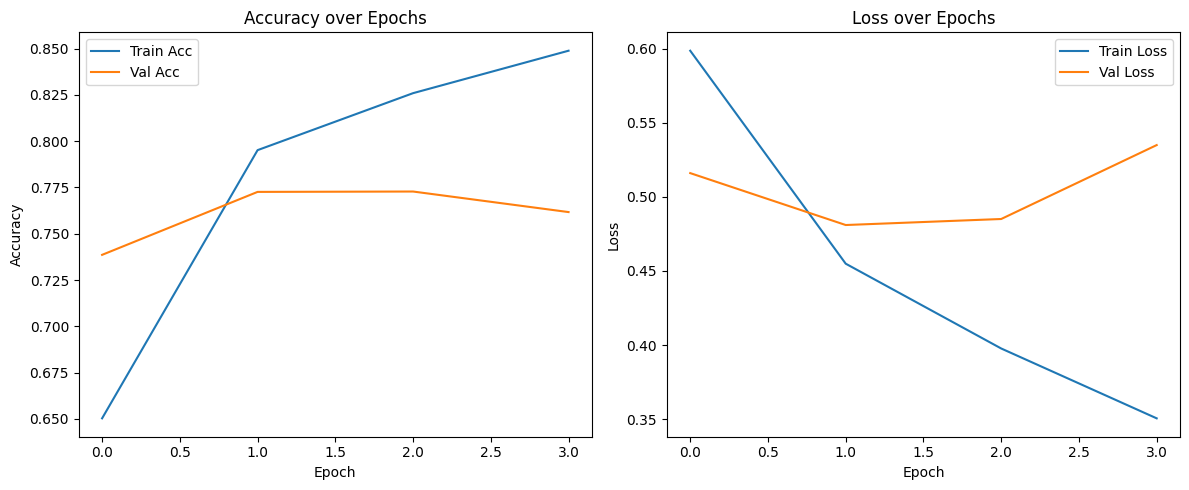

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### Checking accuracy on testing data

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      4977
           1       0.75      0.78      0.77      5023

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



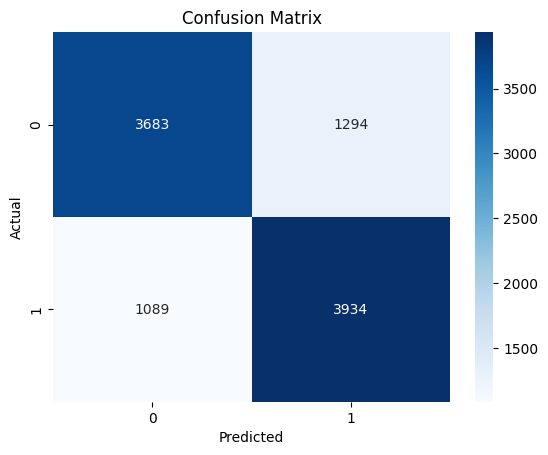

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
